## Pre-requisites

Before running this notebook, you should have already used the `extract_features.py` script to extract features from models trained on DHS data. You should have the following structure under the `outputs/` directory:

```
dhs_ooc/
    DHS_OOC_A_ms_samescaled_b64_fc01_conv01_lr0001/
        features.npz
    ...
    DHS_OOC_E_rgb_same_b64_fc001_conv001_lr0001/
        features.npz
dhs_incountry/
    DHS_Incountry_A_ms_samescaled_b64_fc01_conv01_lr001/
        features.npz
    ...
    DHS_Incountry_E_nl_random_b64_fc01_conv01_lr001/
        features.npz
transfer/
    transfer_nlcenter_ms_b64_fc001_conv001_lr0001/
        features.npz
    transfer_nlcenter_rgb_b64_fc001_conv001_lr0001/
        features.npz
        

TODO: update when keep-frac models are added
```

## Instructions

This notebook essentially performs fine-tuning of the final-layer of the Resnet-18 models. However, instead of directly fine-tuning the Resnet-18 models in TensorFlow, we train ridge-regression models using the extracted features. We take this approach for two reasons:

1. It is easier to perform leave-one-group-out ("logo") cross-validated ridge regression using scikit-learn, as opposed to TensorFlow. For out-of-country (OOC) experiments, the left-out group is the test country. For in-country experiments, the left-out group is the test split.
2. We can concatenate the 512-dim features from the RGB/MS CNN models with the 512-dim features from the NL CNN models to form a larger 1024-dim feature vector capturing RGB/MS + NL imagery information. We do this instead of training a CNN with the MS+NL imagery stacked together as an input because we found it to result in better performance.

Because of the extensive cross-validation, each "logo" CV run may take ~2-4 hours. In total, this notebook may take upwards of 15 hours to complete.

After you complete this notebook, use the `model_analysis/dhs_ooc.ipynb` and `model_analysis/dhs_incountry.ipynb` (TODO) notebooks to analyze the final performance of the fine-tuned Resnet-18 models.

## Imports and Constants

In [3]:
import os
os.chdir('C:/Users/aporw/project new/')
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [10]:
from __future__ import annotations

from collections.abc import Iterable

import pickle

import numpy as np
import pandas as pd
import math

from batchers import dataset_constants
# from models.linear_model import ridge_cv
from models.linear_model1 import ridge_cv
from utils.general import load_npz

In [5]:
FOLDS = ['A', 'B', 'C']
SPLITS = ['train', 'val', 'test']
OUTPUTS_ROOT_DIR = 'outputs'
COUNTRIES = dataset_constants.DHS_COUNTRIES

KEEPS = [0.25]
SEEDS = [123]

In [6]:
MODEL_DIRS = {
    # OOC models
    'resnet_rgb_A': 'DHS_OOC_A_ms_samescaled_keep0.25_seed456_v3_b64_fc01_conv01_lr001',
    'resnet_rgb_B': 'DHS_OOC_B_ms_samescaled_keep0.25_seed456_v4_b64_fc01_conv01_lr001',
    'resnet_rgb_C': 'DHS_OOC_C_ms_samescaled_keep0.25_seed456_v4_b64_fc01_conv01_lr001',
#     'resnet_ms_D': 'DHS_OOC_D_ms_samescaled_b64_fc001_conv001_lr01',
#     'resnet_ms_E': 'DHS_OOC_E_ms_samescaled_b64_fc01_conv01_lr001',
    'resnet_nl_A': 'DHS_OOC_A_nl_keep0.25_seed456_v3_b64_fc001_conv001_lr01',
#     'resnet_nl_B': 'DHS_OOC_B_nl_random_b64_fc1.0_conv1.0_lr0001',
#     'resnet_nl_C': 'DHS_OOC_C_nl_random_b64_fc1.0_conv1.0_lr0001',
#     'resnet_nl_D': 'DHS_OOC_D_nl_random_b64_fc1.0_conv1.0_lr01',
#     'resnet_nl_E': 'DHS_OOC_E_nl_random_b64_fc1.0_conv1.0_lr0001',
#     'resnet_rgb_A': 'DHS_OOC_A_rgb_same_b64_fc001_conv001_lr01',
#     'resnet_rgb_B': 'DHS_OOC_B_rgb_same_b64_fc001_conv001_lr0001',
#     'resnet_rgb_C': 'DHS_OOC_C_rgb_same_b64_fc001_conv001_lr0001',
#     'resnet_rgb_D': 'DHS_OOC_D_rgb_same_b64_fc1.0_conv1.0_lr01',
#     'resnet_rgb_E': 'DHS_OOC_E_rgb_same_b64_fc001_conv001_lr0001',

#     # incountry models
    'incountry_resnet_ms_A': 'DHS_IC_A_ms_samescaled_keep0.25_seed456_v6_b64_fc001_conv001_lr01',
    'incountry_resnet_ms_B': 'DHS_IC_B_ms_samescaled_keep0.25_seed456_v6_b64_fc001_conv001_lr01',
    'incountry_resnet_ms_C': 'DHS_IC_C_ms_samescaled_keep0.25_seed456_v6_b64_fc001_conv001_lr01',
#     'incountry_resnet_ms_D': 'DHS_Incountry_D_ms_samescaled_b64_fc001_conv001_lr0001',
#     'incountry_resnet_ms_E': 'DHS_Incountry_E_ms_samescaled_b64_fc001_conv001_lr0001',
    'incountry_resnet_nl_A': 'DHS_IC_A_nl_samescaled_keep0.25_seed456_v2_b64_fc001_conv001_lr01',
    'incountry_resnet_nl_B': 'DHS_IC_B_nl_samescaled_keep0.25_seed456_v2_b64_fc001_conv001_lr01',
    'incountry_resnet_nl_C': 'DHS_IC_C_nl_samescaled_keep0.25_seed456_v2_b64_fc001_conv001_lr01'
#     'incountry_resnet_nl_D': 'DHS_Incountry_D_nl_random_b64_fc1.0_conv1.0_lr0001',
#     'incountry_resnet_nl_E': 'DHS_Incountry_E_nl_random_b64_fc01_conv01_lr001',

#     # transfer models
#     'transfer_resnet_ms': 'transfer_nlcenter_ms_b64_fc001_conv001_lr0001',
#     'transfer_resnet_rgb': 'transfer_nlcenter_rgb_b64_fc001_conv001_lr0001',

    # keep-frac models
    # TODO
}

## Load data

`country_labels` is a `np.ndarray` that shows which country each cluster belongs to. Countries are indexed by their position in `dataset_constants.DHS_COUNTRIES`.
```python
array([ 0,  0,  0, ..., 22, 22, 22])
```

`incountry_group_labels` is a `np.ndarray` that shows which "test" fold each cluster belongs to. The first cluster belongs to the "test" split of fold "B" (folds here are 0-indexed).
```python
array([1, 1, 4, ..., 1, 0, 3])
```

In [7]:
df = pd.read_csv('data/dhs_clusters.csv', float_precision='high', index_col=False)
labels = df['wealthscore'].to_numpy(dtype=np.float32)
locs = df[['lat', 'lon']].to_numpy(dtype=np.float32)
country_labels = df['country'].map(COUNTRIES.index).to_numpy()

with open('data/dhs_incountry_folds.pkl', 'rb') as f:
    incountry_folds = pickle.load(f)

incountry_group_labels = np.zeros(len(df), dtype=np.int64)
for i, fold in enumerate(FOLDS):
    test_indices = incountry_folds[fold]['test']
    incountry_group_labels[test_indices] = i

## OOC

In [145]:
def ridgecv_ooc_wrapper(model_name: str, savedir: str) -> None:
    '''
    Args
    - model_name: str, corresponds to keys in MODEL_DIRS (without the fold suffix)
    - savedir: str, path to directory for saving ridge regression weights and predictions
    '''
    features_dict = {}
    for f in FOLDS:
        model_fold_name = f'{model_name}_{f}'
        model_dir = MODEL_DIRS[model_fold_name]
        npz_path = os.path.join(OUTPUTS_ROOT_DIR, model_dir, 'features.npz')
        npz = load_npz(npz_path, check={'labels': labels})
        features = npz['features']
        for country in dataset_constants.SURVEY_NAMES[f'DHS_OOC_{f}']['test']:
            features_dict[country] = features
#     print(features_dict)
    ridge_cv(
        features=features_dict,
        labels=labels,
        group_labels=country_labels,
        group_names=COUNTRIES,
        do_plot=True,
        savedir=savedir,
        save_weights=True,
        save_dict=dict(locs=locs))
#     from sklearn.linear_model import LinearRegression
    
#     model = LinearRegression().fit(features_dict["nigeria"], labels)
#     r_sq = model.score(features_dict["nigeria"], labels)
#     print(r_sq)

Each of the following 3 cells make take ~2 hours each to run.

features: dtype=float32, shape=(1857, 512)
preds: dtype=float32, shape=(1857,)
labels: dtype=float32, shape=(1857,)
locs: dtype=float32, shape=(1857, 2)
years: dtype=int32, shape=(1857,)
features: dtype=float32, shape=(1857, 512)
preds: dtype=float32, shape=(1857,)
labels: dtype=float32, shape=(1857,)
locs: dtype=float32, shape=(1857, 2)
years: dtype=int32, shape=(1857,)
features: dtype=float32, shape=(1857, 512)
preds: dtype=float32, shape=(1857,)
labels: dtype=float32, shape=(1857,)
locs: dtype=float32, shape=(1857, 2)
years: dtype=int32, shape=(1857,)
Group: malawi


C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users

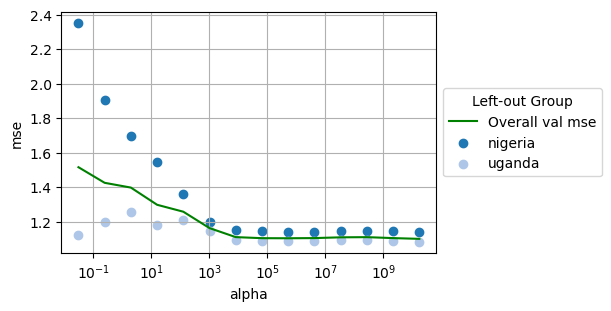

best val mse: 1.110, best alpha: 8192.0, test mse: 0.917
Group: nigeria


C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.97011e-08): result may not be accurate.
  overwrite_a=True).T
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.37521e-08): result may not be accurate.
  overwrite_a=True).T


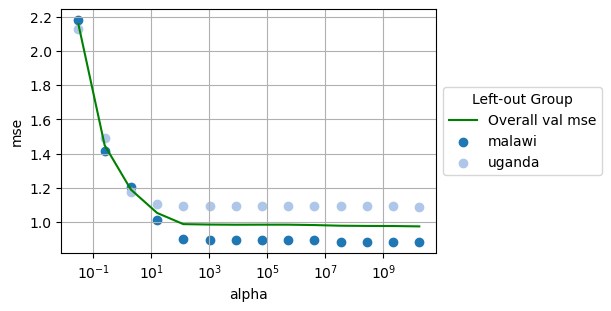

best val mse: 0.989, best alpha: 128.0, test mse: 1.204
Group: uganda


C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users

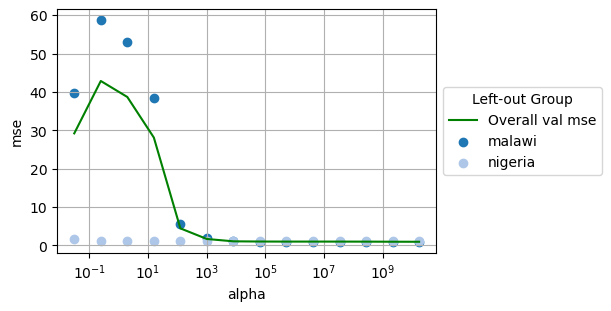

best val mse: 1.018, best alpha: 65536.0, test mse: 1.090
saving test preds to: outputs\resnet_rgb2\test_preds.npz
saving ridge_weights to: outputs\resnet_rgb2\ridge_weights.npz


In [167]:
model_name = 'resnet_rgb'
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'resnet_rgb')
ridgecv_ooc_wrapper(model_name, savedir)

In [122]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(features_dict["nigeria"], labels)
r_sq = model.score(features_dict["nigeria"], labels)
print(r_sq)

NameError: name 'features_dict' is not defined

features: dtype=float32, shape=(1857, 512)
preds: dtype=float32, shape=(1857,)
labels: dtype=float32, shape=(1857,)
locs: dtype=float32, shape=(1857, 2)
years: dtype=int32, shape=(1857,)
[[ 315.23624  311.55984 -306.20544 ...  312.58545 -315.3984  -315.16025]
 [ 339.07645  335.5447  -326.21417 ...  336.4481  -339.516   -339.07498]
 [ 338.03674  334.43634 -326.12457 ...  335.38043 -338.4262  -338.03543]
 ...
 [ 306.19284  302.4249  -298.9245  ...  303.53052 -306.20413 -306.06125]
 [ 291.19827  287.34183 -286.34372 ...  288.53363 -291.02206 -291.00238]
 [ 284.76453  280.85974 -281.02997 ...  282.09424 -284.50497 -284.54318]]
[   808.61536 -18973.223   -32122.1     ...  -5525.643    -1824.3
 -19000.072  ]
[2 2 2 ... 0 0 0]
['malawi', 'nigeria', 'uganda']
Group: malawi


C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users

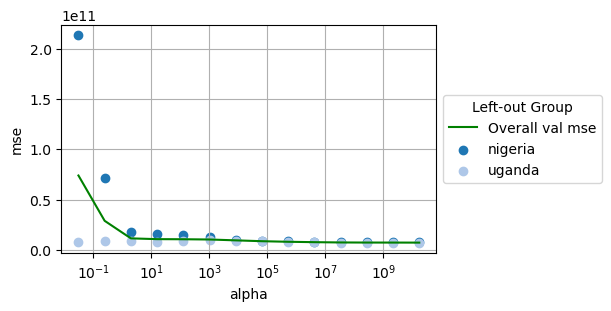

best val mse: 7266392031.906, best alpha: 17179869184.0, test mse: 5677444608.000
Group: nigeria


C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.48594e-09): result may not be accurate.
  overwrite_a=True).T
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.09767e-09): result may not be accurate.
  overwrite_a=True).T
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.95689e-08): result may not be accurate.
  overwrite_a=True).T


best val mse: 6357405830.886, best alpha: 33554432.0, test mse: 7454349824.000
Group: uganda


C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users

best val mse: 6070859826.212, best alpha: 524288.0, test mse: 7568258560.000
saving test preds to: outputs\dhs_ooc\resnet_nl\test_preds.npz
saving ridge_weights to: outputs\dhs_ooc\resnet_nl\ridge_weights.npz


In [52]:
model_name = 'resnet_nl'
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'dhs_ooc', 'resnet_nl')
ridgecv_ooc_wrapper(model_name, savedir)

### Concatenated RGB/MS + NL features

In [59]:
def ridgecv_ooc_concat_wrapper(model_names: Iterable[str], savedir: str) -> None:
    '''
    Args
    - model_names: list of str, correspond to keys in MODEL_DIRS (without the fold suffix)
    - savedir: str, path to directory for saving ridge regression weights and predictions
    '''
    features_dict = {}
    for f in FOLDS:
        concat_features = []  # list of np.array, each shape [N, D_i]
        for model_name in model_names:
            model_dir = MODEL_DIRS[f'{model_name}_{f}']
            npz_path = os.path.join(OUTPUTS_ROOT_DIR, model_dir, 'features.npz')
            npz = load_npz(npz_path, check={'labels': labels})
            concat_features.append(npz['features'])
        concat_features = np.concatenate(concat_features, axis=1)  # shape [N, D_1 + ... + D_m]
#         for country in dataset_constants.SURVEY_NAMES[f'DHS_OOC_{f}']['test']:
#             features_dict[country] = concat_features

    ridge_cv(
        features=concat_features,
        labels=labels,
        group_labels=country_labels,
        group_names=COUNTRIES,
        do_plot=True,
        savedir=savedir,
        save_weights=True,
        save_dict=dict(locs=locs),
        verbose=True)

Each of the following 2 cells make take ~3-4 hours each to run.

In [ ]:
model_names = ['resnet_ms', 'resnet_nl']
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'dhs_ooc', 'resnet_msnl_concat')
ridgecv_ooc_concat_wrapper(model_names, savedir)

features: dtype=float32, shape=(1857, 512)
preds: dtype=float32, shape=(1857,)
labels: dtype=float32, shape=(1857,)
locs: dtype=float32, shape=(1857, 2)
years: dtype=int32, shape=(1857,)
features: dtype=float32, shape=(1857, 512)
preds: dtype=float32, shape=(1857,)
labels: dtype=float32, shape=(1857,)
locs: dtype=float32, shape=(1857, 2)
years: dtype=int32, shape=(1857,)
Group: malawi
Alpha: 0.03125 (1/14)

C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


Alpha: 2.0 (3/14)

C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


Alpha: 128.0 (5/14)

C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


Alpha: 65536.0 (8/14)

C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.71751e-10): result may not be accurate.
  overwrite_a=False)
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.73099e-09): result may not be accurate.
  overwrite_a=False)
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.74517e-08): result may not be accurate.
  overwrite_a=False)


Alpha: 17179869184.0 (14/14)


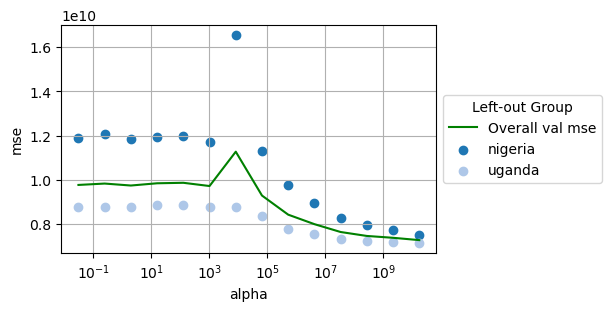

best val mse: 7280761823.085, best alpha: 17179869184.0, test mse: 5676747264.000
Group: nigeria
Alpha: 0.03125 (1/14)

C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


Alpha: 0.25 (2/14)

C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


Alpha: 2.0 (3/14)

C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


Alpha: 16.0 (4/14)

C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


Alpha: 128.0 (5/14)

C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


Alpha: 1024.0 (6/14)

C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


Alpha: 524288.0 (9/14)

C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.71751e-10): result may not be accurate.
  overwrite_a=False)
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.667e-10): result may not be accurate.
  overwrite_a=False)
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.74517e-08): result may not be accurate.
  overwrite_a=False)
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.32602e-08): result may not be accurate.
  overwrite_a=False)


Alpha: 17179869184.0 (14/14)
best val mse: 6358581420.042, best alpha: 17179869184.0, test mse: 7318917120.000
Group: uganda
Alpha: 0.03125 (1/14)

C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


Alpha: 2.0 (3/14)

C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


Alpha: 128.0 (5/14)

C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users

Alpha: 8192.0 (7/14)

C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.73099e-09): result may not be accurate.
  overwrite_a=False)
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.667e-10): result may not be accurate.
  overwrite_a=False)
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.32602e-08): result may not be accurate.
  overwrite_a=False)


Alpha: 17179869184.0 (14/14)
best val mse: 6082748059.471, best alpha: 17179869184.0, test mse: 7105229824.000
saving test preds to: outputs\resnet_rgbnl_concat\test_preds.npz
saving ridge_weights to: outputs\resnet_rgbnl_concat\ridge_weights.npz


In [60]:
model_names = ['resnet_rgb', 'resnet_nl']
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'resnet_rgbnl_concat')
ridgecv_ooc_concat_wrapper(model_names, savedir)

## Incountry

In [11]:
def ridgecv_incountry_wrapper(model_name: str, savedir: str) -> None:
    '''
    Args
    - model_name: str, corresponds to keys in MODEL_DIRS (without the fold suffix)
    - savedir: str, path to directory for saving ridge regression weights and predictions
    '''
    features_dict = {}
    for f in FOLDS:
        model_fold_name = f'{model_name}_{f}'
        model_dir = MODEL_DIRS[model_fold_name]
        npz_path = os.path.join(OUTPUTS_ROOT_DIR, model_dir, 'features.npz')
        npz = load_npz(npz_path, check={'labels': labels})
        features_dict[f] = npz['features']

    ridge_cv(
        features=features_dict,
        labels=labels,
        group_labels=incountry_group_labels,
        group_names=FOLDS,
        do_plot=True,
        savedir=savedir,
        save_weights=True,
        verbose=True)

In [12]:
model_name = 'incountry_resnet_ms'
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'resnet_ms3')
ridgecv_incountry_wrapper(model_name, savedir)

features: dtype=float32, shape=(1857, 512)
preds: dtype=float32, shape=(1857,)
labels: dtype=float32, shape=(1857,)
locs: dtype=float32, shape=(1857, 2)
years: dtype=int32, shape=(1857,)
features: dtype=float32, shape=(1857, 512)
preds: dtype=float32, shape=(1857,)
labels: dtype=float32, shape=(1857,)
locs: dtype=float32, shape=(1857, 2)
years: dtype=int32, shape=(1857,)
features: dtype=float32, shape=(1857, 512)
preds: dtype=float32, shape=(1857,)
labels: dtype=float32, shape=(1857,)
locs: dtype=float32, shape=(1857, 2)
years: dtype=int32, shape=(1857,)


TypeError: must be real number, not dict

features: dtype=float32, shape=(1857, 512)
preds: dtype=float32, shape=(1857,)
labels: dtype=float32, shape=(1857,)
locs: dtype=float32, shape=(1857, 2)
years: dtype=int32, shape=(1857,)
features: dtype=float32, shape=(1857, 512)
preds: dtype=float32, shape=(1857,)
labels: dtype=float32, shape=(1857,)
locs: dtype=float32, shape=(1857, 2)
years: dtype=int32, shape=(1857,)
features: dtype=float32, shape=(1857, 512)
preds: dtype=float32, shape=(1857,)
labels: dtype=float32, shape=(1857,)
locs: dtype=float32, shape=(1857, 2)
years: dtype=int32, shape=(1857,)
Group: A
Alpha: 17179869184.0 (14/14)


C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.68826e-08): result may not be accurate.
  overwrite_a=True).T
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.65643e-09): result may not be accurate.
  overwrite_a=True).T


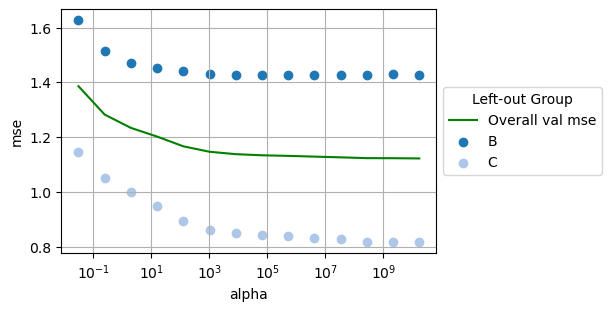

best val mse: 1.131, best alpha: 524288.0, test mse: 0.870
Group: B
Alpha: 8192.0 (7/14))

C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.50863e-08): result may not be accurate.
  overwrite_a=True).T
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.59227e-08): result may not be accurate.
  overwrite_a=True).T


Alpha: 17179869184.0 (14/14)


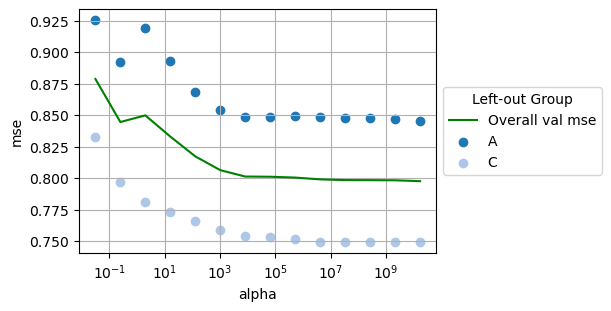

C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.75588e-09): result may not be accurate.
  overwrite_a=True).T


best val mse: 0.801, best alpha: 8192.0, test mse: 1.421
Group: C
Alpha: 8192.0 (7/14))

C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.93981e-09): result may not be accurate.
  overwrite_a=True).T
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.59568e-09): result may not be accurate.
  overwrite_a=True).T


Alpha: 17179869184.0 (14/14)


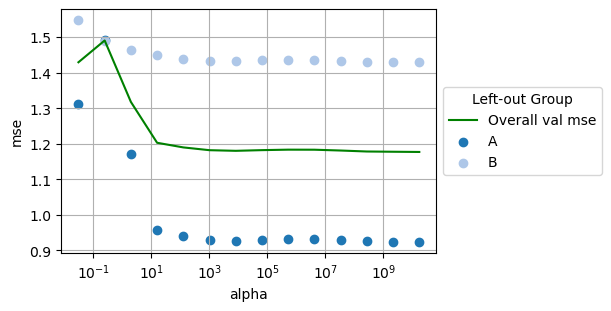

best val mse: 1.182, best alpha: 1024.0, test mse: 0.764
saving test preds to: outputs\resnet_nl2\test_preds.npz
saving ridge_weights to: outputs\resnet_nl2\ridge_weights.npz


In [215]:
model_name = 'incountry_resnet_nl'
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'resnet_nl2')
ridgecv_incountry_wrapper(model_name, savedir)

### Concatenated MS + NL Features

In [184]:
def ridgecv_incountry_concat_wrapper(model_names: Iterable[str], savedir: str) -> None:
    '''
    Args
    - model_names: list of str, correspond to keys in MODEL_DIRS (without the fold suffix)
    - savedir: str, path to directory for saving ridge regression weights and predictions
    '''
    features_dict = {}
    for i, f in enumerate(FOLDS):
        concat_features = []  # list of np.array, each shape [N, D_i]
        for model_name in model_names:
            model_dir = MODEL_DIRS[f'{model_name}_{f}']
            npz_path = os.path.join(OUTPUTS_ROOT_DIR, model_dir, 'features.npz')
            npz = load_npz(npz_path, check={'labels': labels})
            concat_features.append(npz['features'])
        concat_features = np.concatenate(concat_features, axis=1)  # shape [N, D_1 + ... + D_m]
        features_dict[f] = concat_features

    ridge_cv(
        features=features_dict,
        labels=labels,
        group_labels=incountry_group_labels,
        group_names=FOLDS,
        do_plot=True,
        savedir=savedir,
        save_weights=True,
        verbose=True)

features: dtype=float32, shape=(1857, 512)
preds: dtype=float32, shape=(1857,)
labels: dtype=float32, shape=(1857,)
locs: dtype=float32, shape=(1857, 2)
years: dtype=int32, shape=(1857,)
features: dtype=float32, shape=(1857, 512)
preds: dtype=float32, shape=(1857,)
labels: dtype=float32, shape=(1857,)
locs: dtype=float32, shape=(1857, 2)
years: dtype=int32, shape=(1857,)
features: dtype=float32, shape=(1857, 512)
preds: dtype=float32, shape=(1857,)
labels: dtype=float32, shape=(1857,)
locs: dtype=float32, shape=(1857, 2)
years: dtype=int32, shape=(1857,)
features: dtype=float32, shape=(1857, 512)
preds: dtype=float32, shape=(1857,)
labels: dtype=float32, shape=(1857,)
locs: dtype=float32, shape=(1857, 2)
years: dtype=int32, shape=(1857,)
features: dtype=float32, shape=(1857, 512)
preds: dtype=float32, shape=(1857,)
labels: dtype=float32, shape=(1857,)
locs: dtype=float32, shape=(1857, 2)
years: dtype=int32, shape=(1857,)
features: dtype=float32, shape=(1857, 512)
preds: dtype=float32, 

C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users

Alpha: 8192.0 (7/14)

C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users

Alpha: 17179869184.0 (14/14)


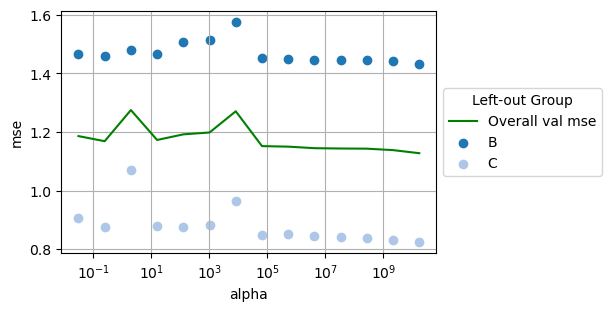

best val mse: 1.138, best alpha: 2147483648.0, test mse: 0.870
Group: B
Alpha: 2.0 (3/14)

C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users

Alpha: 1024.0 (6/14)

C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users

Alpha: 2147483648.0 (13/14)

C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=6.59434e-09): result may not be accurate.
  overwrite_a=False)
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.45956e-09): result may not be accurate.
  overwrite_a=False)


Alpha: 17179869184.0 (14/14)


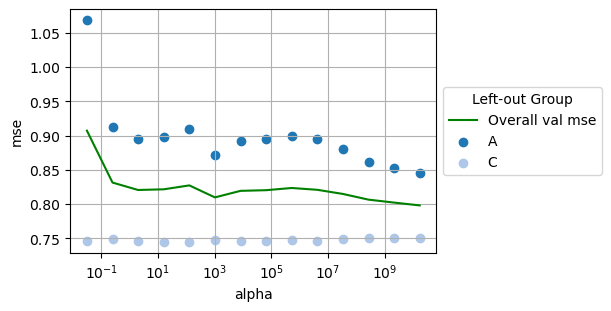

best val mse: 0.802, best alpha: 2147483648.0, test mse: 1.426
Group: C
Alpha: 2.0 (3/14)

C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users

Alpha: 1024.0 (6/14)

C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\aporw\anaconda3\envs\r3py3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users

Alpha: 17179869184.0 (14/14)


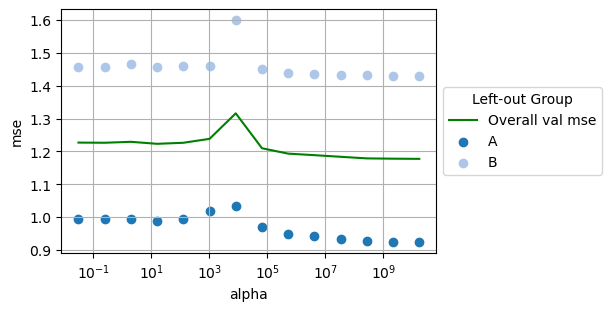

best val mse: 1.189, best alpha: 4194304.0, test mse: 0.760
saving test preds to: outputs\resnet_msnl_concat2\test_preds.npz
saving ridge_weights to: outputs\resnet_msnl_concat2\ridge_weights.npz


In [216]:
model_names = ['incountry_resnet_ms', 'incountry_resnet_nl']
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'resnet_msnl_concat2')
ridgecv_incountry_concat_wrapper(model_names, savedir)

### Transfer

In [ ]:
def ridgecv_incountry_transfer_wrapper(model_name: str, savedir: str) -> None:
    '''
    Args
    - model_name: str, corresponds to keys in MODEL_DIRS (without the fold suffix)
    - savedir: str, path to directory for saving ridge regression weights and predictions
    '''
    model_dir = MODEL_DIRS[model_name]
    npz_path = os.path.join(OUTPUTS_ROOT_DIR, 'transfer', model_dir, 'features.npz')
    features = load_npz(npz_path, check={'labels': labels})['features']
    ridge_cv(
        features=features,
        labels=labels,
        group_labels=incountry_group_labels,
        group_names=FOLDS,
        do_plot=True,
        savedir=savedir,
        save_weights=False)

In [ ]:
model_name = 'transfer_resnet_ms'
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'transfer', MODEL_DIRS[model_name])
ridgecv_incountry_transfer_wrapper(model_name, savedir)

In [ ]:
model_name = 'transfer_resnet_rgb'
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'transfer', MODEL_DIRS[model_name])
ridgecv_incountry_transfer_wrapper(model_name, savedir)